<a href="https://colab.research.google.com/github/Aquib88raza/image-classification-ANKLE/blob/main/multiclass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import os
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from keras.applications import MobileNetV2
from keras.models import Model
from keras.layers import GlobalAveragePooling2D, Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import MinMaxScaler

In [7]:
# @title DEFINITIONS

classifiers_names = [
    "KNeighborsClassifier",
    "SVC",
    'MultinomialNB',
    "DecisionTreeClassifier",
    "RandomForestClassifier"
]

classifiers = [
    KNeighborsClassifier(),
    SVC(),
    MultinomialNB(),
    DecisionTreeClassifier(),
    RandomForestClassifier()
]

parameters = [
    {'n_neighbors': [3, 5, 7, 9, 11, 13]},  # KNeighborsClassifier
    {'C': [1, 10, 50, 70, 100], 'gamma':['scale', 'auto'], 'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'class_weight': [None, 'balanced']}, # SVC
    {'alpha': [0.1, 0.5, 1.0]},  # MultinomialNB
    {'max_depth': [None, 3, 5, 7, 10]},  # DecisionTreeClassifier
    {'n_estimators': [50, 100, 200, 300, 500], 'warm_start': [True, False], 'n_jobs':[None, 1, 2, 3]}  # RandomForestClassifier
]

# Initialize MobileNetV2 for feature extraction with additional layers
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Add custom layers on top of MobileNetV2
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1012, activation='relu')(x)  # Add more layers if needed
x = Dropout(0.5)(x)  # Add dropout for regularization

# Define class labels for multi-class problem
class_labels = ["healthy", "ill", "minimal", "moderate"]

# Adjust the output layer based on the number of classes
predictions = Dense(len(class_labels), activation='softmax')(x)

# Create the new model
model = Model(inputs=base_model.input, outputs=predictions)

# Set MobileNetV2 layers as non-trainable (optional)
for layer in base_model.layers:
    layer.trainable = False

# Paths to dataset folders
base_path = "/content/drive/MyDrive/knee osteo 2"  # Change to your dataset path

# Define class labels for multi-class problem
class_labels = ["healthy", "ill", "minimal", "moderate"]

dataset_images_names = []
dataset_images = []
dataset_labels = []

for label in class_labels:
    label_path = os.path.join(base_path, label)
    for filename in os.listdir(label_path):
        if filename.endswith(".jpg"):
            filepath = os.path.join(label_path, filename)
            image = cv2.imread(filepath)

            if image is not None and not image.size == 0:
                size = (128, 128)
                image = cv2.resize(image, size, interpolation=cv2.INTER_AREA)
                dataset_images.append(image)
                dataset_labels.append(label)
            else:
                print(f"Error loading or resizing image: {filepath}")

# Convert labels to numerical values
class_to_idx = {class_labels[i]: i for i in range(len(class_labels))}
dataset_labels = [class_to_idx[label] for label in dataset_labels]

# Shuffle the dataset
combined_arrays = list(zip(dataset_images, dataset_labels))
random.shuffle(combined_arrays)
shuffled_images, shuffled_labels = zip(*combined_arrays)
dataset_images = np.array(shuffled_images)
dataset_labels = np.array(shuffled_labels)

# Apply LDA for feature extraction
lda = LDA(n_components=2)  # You can adjust the number of components as needed
dataset_features = lda.fit_transform(dataset_images.reshape(-1, 128 * 128 * 3), dataset_labels)
# Apply Min-Max scaling to the dataset
scaler = MinMaxScaler()
scaled_dataset_features = scaler.fit_transform(dataset_features)

In [9]:
best_models = []
acc_cross = []
var_cross = []
pred_reports = []
pred_cross = []
roc_curves = []
auc_scores = []

for i in range(len(classifiers)):
    model = classifiers[i]
    model_name = classifiers_names[i]
    param_grid = parameters[i]

    # Grid Search for best parameters of models in terms of accuracy
    best_model = GridSearchCV(model, param_grid, scoring='accuracy', cv=StratifiedKFold(n_splits=8))

    # Model Fitting
    best_model.fit(scaled_dataset_features, dataset_labels)
    best_models.append(best_model)

    # Checking the params
    params = best_model.get_params()
    print(f'{model_name} -> {params}')

    # SCORING
    cv_accuracy = cross_val_score(best_model.best_estimator_, scaled_dataset_features, dataset_labels, scoring='accuracy', cv=StratifiedKFold(n_splits=8))

    # ACCURACY
    print(f'{model_name} - Accuracy using cross-validation: {cv_accuracy.mean()*100.0} %')
    acc_cross.append(f'{cv_accuracy.mean()*100.0} %')

    # VARIANCE
    print(f'{model_name} - Variance using cross-validation: {cv_accuracy.var()*100.0} %')
    var_cross.append(f'{cv_accuracy.var()}')
    print()

    # PREDICTIONS
    cv_predict = cross_val_predict(best_model.best_estimator_, scaled_dataset_features, dataset_labels, cv=StratifiedKFold(n_splits=8))
    classes = class_labels
    pred_reports.append(classification_report(dataset_labels, cv_predict, target_names=classes))
    pred_cross.append(cv_predict)

    print(f'Done with classification: {model_name}')


KNeighborsClassifier -> {'cv': StratifiedKFold(n_splits=8, random_state=None, shuffle=False), 'error_score': nan, 'estimator__algorithm': 'auto', 'estimator__leaf_size': 30, 'estimator__metric': 'minkowski', 'estimator__metric_params': None, 'estimator__n_jobs': None, 'estimator__n_neighbors': 5, 'estimator__p': 2, 'estimator__weights': 'uniform', 'estimator': KNeighborsClassifier(), 'n_jobs': None, 'param_grid': {'n_neighbors': [3, 5, 7, 9, 11, 13]}, 'pre_dispatch': '2*n_jobs', 'refit': True, 'return_train_score': False, 'scoring': 'accuracy', 'verbose': 0}
KNeighborsClassifier - Accuracy using cross-validation: 90.13713080168777 %
KNeighborsClassifier - Variance using cross-validation: 0.008428804144634957 %

Done with classification: KNeighborsClassifier
SVC -> {'cv': StratifiedKFold(n_splits=8, random_state=None, shuffle=False), 'error_score': nan, 'estimator__C': 1.0, 'estimator__break_ties': False, 'estimator__cache_size': 200, 'estimator__class_weight': None, 'estimator__coef0':

KNeighborsClassifier -> {'cv': StratifiedKFold(n_splits=8, random_state=None, shuffle=False), 'error_score': nan, 'estimator__algorithm': 'auto', 'estimator__leaf_size': 30, 'estimator__metric': 'minkowski', 'estimator__metric_params': None, 'estimator__n_jobs': None, 'estimator__n_neighbors': 5, 'estimator__p': 2, 'estimator__weights': 'uniform', 'estimator': KNeighborsClassifier(), 'n_jobs': None, 'param_grid': {'n_neighbors': [3, 5, 7, 9, 11, 13]}, 'pre_dispatch': '2*n_jobs', 'refit': True, 'return_train_score': False, 'scoring': 'accuracy', 'verbose': 0}
Accuracy using cross-validation: 90.13713080168777 %
Variance using cross-validation: 8.428804144634957e-05


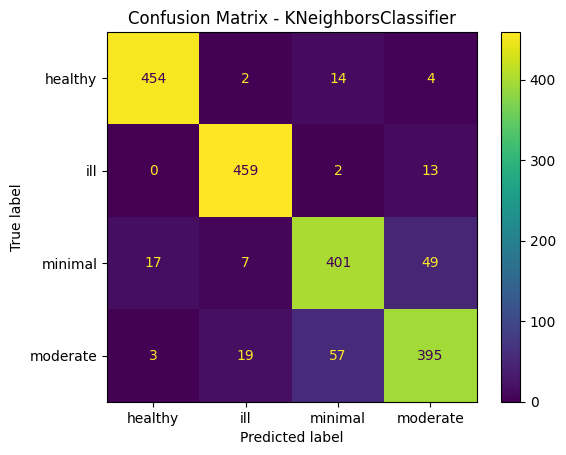


Classification Report - KNeighborsClassifier:
              precision    recall  f1-score   support

     healthy       0.96      0.96      0.96       474
         ill       0.94      0.97      0.96       474
     minimal       0.85      0.85      0.85       474
    moderate       0.86      0.83      0.84       474

    accuracy                           0.90      1896
   macro avg       0.90      0.90      0.90      1896
weighted avg       0.90      0.90      0.90      1896



SVC -> {'cv': StratifiedKFold(n_splits=8, random_state=None, shuffle=False), 'error_score': nan, 'estimator__C': 1.0, 'estimator__break_ties': False, 'estimator__cache_size': 200, 'estimator__class_weight': None, 'estimator__coef0': 0.0, 'estimator__decision_function_shape': 'ovr', 'estimator__degree': 3, 'estimator__gamma': 'scale', 'estimator__kernel': 'rbf', 'estimator__max_iter': -1, 'estimator__probability': False, 'estimator__random_state': None, 'estimator__shrinking': True, 'estimator__tol': 0.001, 'est

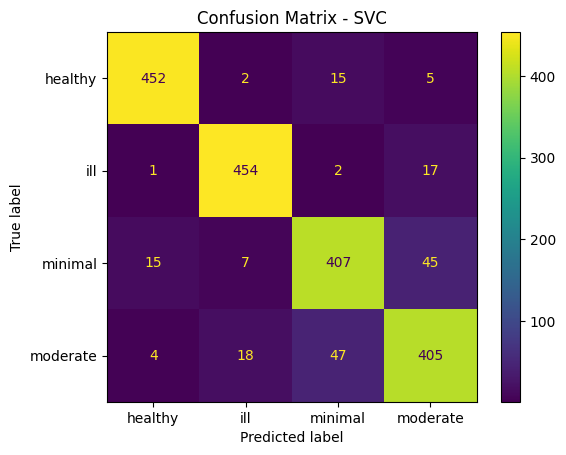


Classification Report - SVC:
              precision    recall  f1-score   support

     healthy       0.96      0.95      0.96       474
         ill       0.94      0.96      0.95       474
     minimal       0.86      0.86      0.86       474
    moderate       0.86      0.85      0.86       474

    accuracy                           0.91      1896
   macro avg       0.91      0.91      0.91      1896
weighted avg       0.91      0.91      0.91      1896



MultinomialNB -> {'cv': StratifiedKFold(n_splits=8, random_state=None, shuffle=False), 'error_score': nan, 'estimator__alpha': 1.0, 'estimator__class_prior': None, 'estimator__fit_prior': True, 'estimator__force_alpha': 'warn', 'estimator': MultinomialNB(), 'n_jobs': None, 'param_grid': {'alpha': [0.1, 0.5, 1.0]}, 'pre_dispatch': '2*n_jobs', 'refit': True, 'return_train_score': False, 'scoring': 'accuracy', 'verbose': 0}
Accuracy using cross-validation: 61.9198312236287 %
Variance using cross-validation: 0.0007199255817265755


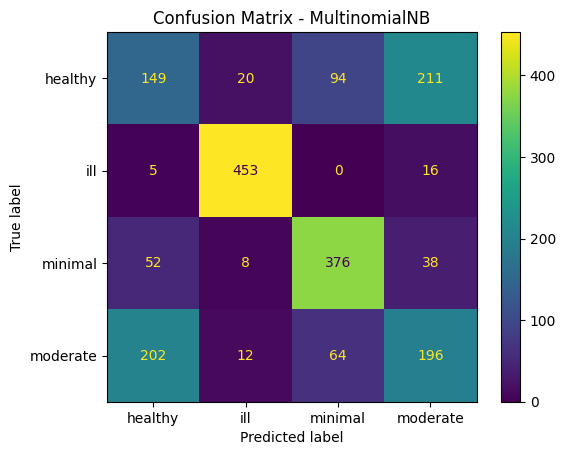


Classification Report - MultinomialNB:
              precision    recall  f1-score   support

     healthy       0.37      0.31      0.34       474
         ill       0.92      0.96      0.94       474
     minimal       0.70      0.79      0.75       474
    moderate       0.43      0.41      0.42       474

    accuracy                           0.62      1896
   macro avg       0.60      0.62      0.61      1896
weighted avg       0.60      0.62      0.61      1896



DecisionTreeClassifier -> {'cv': StratifiedKFold(n_splits=8, random_state=None, shuffle=False), 'error_score': nan, 'estimator__ccp_alpha': 0.0, 'estimator__class_weight': None, 'estimator__criterion': 'gini', 'estimator__max_depth': None, 'estimator__max_features': None, 'estimator__max_leaf_nodes': None, 'estimator__min_impurity_decrease': 0.0, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 2, 'estimator__min_weight_fraction_leaf': 0.0, 'estimator__random_state': None, 'estimator__splitter': 'best

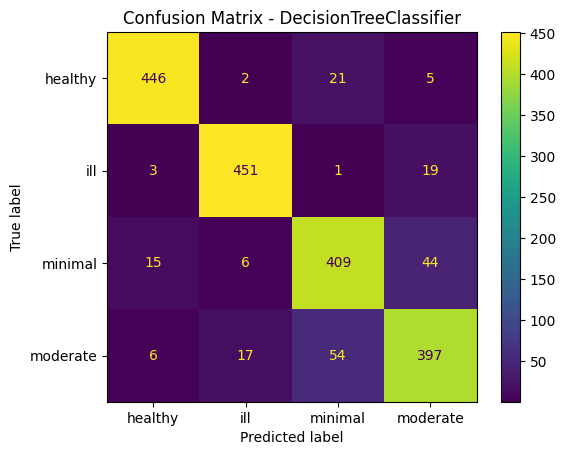


Classification Report - DecisionTreeClassifier:
              precision    recall  f1-score   support

     healthy       0.95      0.94      0.94       474
         ill       0.95      0.95      0.95       474
     minimal       0.84      0.86      0.85       474
    moderate       0.85      0.84      0.85       474

    accuracy                           0.90      1896
   macro avg       0.90      0.90      0.90      1896
weighted avg       0.90      0.90      0.90      1896



RandomForestClassifier -> {'cv': StratifiedKFold(n_splits=8, random_state=None, shuffle=False), 'error_score': nan, 'estimator__bootstrap': True, 'estimator__ccp_alpha': 0.0, 'estimator__class_weight': None, 'estimator__criterion': 'gini', 'estimator__max_depth': None, 'estimator__max_features': 'sqrt', 'estimator__max_leaf_nodes': None, 'estimator__max_samples': None, 'estimator__min_impurity_decrease': 0.0, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 2, 'estimator__min_weight_fraction_

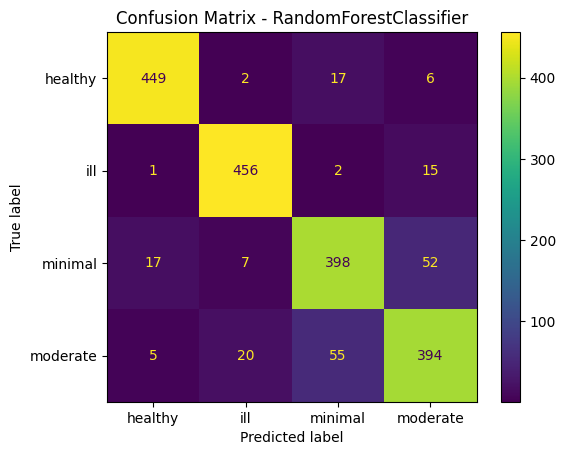


Classification Report - RandomForestClassifier:
              precision    recall  f1-score   support

     healthy       0.95      0.95      0.95       474
         ill       0.94      0.96      0.95       474
     minimal       0.84      0.84      0.84       474
    moderate       0.84      0.83      0.84       474

    accuracy                           0.90      1896
   macro avg       0.89      0.90      0.89      1896
weighted avg       0.89      0.90      0.89      1896





In [10]:
# @title PARAMETERS, ACCURACIES, VARIANCES, CONFUSION MATRICES, CLASSIFICATION REPORT

for i in range(len(best_models)):
    # name
    model_name = classifiers_names[i]

    # Checking the params
    params = best_models[i].get_params()
    print(f'{model_name} -> {params}')

    # ACCURACY
    print(f'Accuracy using cross-validation: {acc_cross[i]}')

    # VARIANCE
    print(f'Variance using cross-validation: {var_cross[i]}')

    # CONFUSION MATRICES
    cm = confusion_matrix(dataset_labels, pred_cross[i])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot()
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()
    print()

    # CLASSIFICATION REPORT
    print(f'Classification Report - {model_name}:')
    print(pred_reports[i])

    print()
    print()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')